In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys 
sys.path.insert(0, '../src/')

from astropy.table import Table
import warnings; warnings.simplefilter('ignore')
import emcee
import corner

In [25]:
def cumulative(lgMs_1D):
    """

    Args:
        Ms (numpy): 1D mass array
        mass_bins (numpy): mass bins

    Returns:
        CSMF (numpy): counts in each bin
    """

    mass_bins = np.linspace(4,11,45)

    N = np.histogram(lgMs_1D, bins=mass_bins)[0]
    Nsub = np.sum(N)
    stat = Nsub-np.cumsum(N) 
    return np.insert(stat, 0, Nsub) #to add the missing index

def SHMR(lgMh_2D, alpha=1.85, delta=0.2, sigma=0.3):

    """
    Returns: the log stellar mass array with an added dimension corresponding to the random samples
    """

    M_star_a = 10 # these are the anchor points
    M_halo_a = 11.67

    #print("not normalizing for the upscatter and assuming a 2D input array")
    lgMs_2D = alpha*(lgMh_2D-M_halo_a) - delta*(lgMh_2D-M_halo_a)**2 + M_star_a
    scatter = np.random.normal(loc=0, scale=sigma, size=(lgMs_2D.shape))
    return lgMs_2D + scatter

def MODEL(theta):
    
    alpha, delta, sigma = theta

    data = np.load("../../data/3000_12_8/truth_lgMh.npy")
    lgMs_2D = SHMR(data, alpha, delta, sigma) # will be a 3D array if sigma is non zero
    
    counts = np.apply_along_axis(cumulative, 1, lgMs_2D)
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter

    S1 = quant[2, 16] - quant[0, 16] #16, 22, 28 corresponds to 6.5, 7, 7.5 Msol
    S2 = quant[2, 22] - quant[0, 22]
    S3 = quant[2, 28] - quant[0, 28]
    N1 = quant[1, 16]
    N2 = quant[1, 22]
    N3 = quant[1, 28]

    model = np.array([N1, N2, N3, S1, S2, S3])

    return quant

In [26]:
theta1 = [2.6, 0, 2]

theta2 = [2.6, 0, 0]

theta3 = [1.8, 0, 0]

In [27]:
quant1 = MODEL(theta1)

quant2 = MODEL(theta2)

quant3 = MODEL(theta3)

In [28]:
mass_bins = np.linspace(4,11,45)


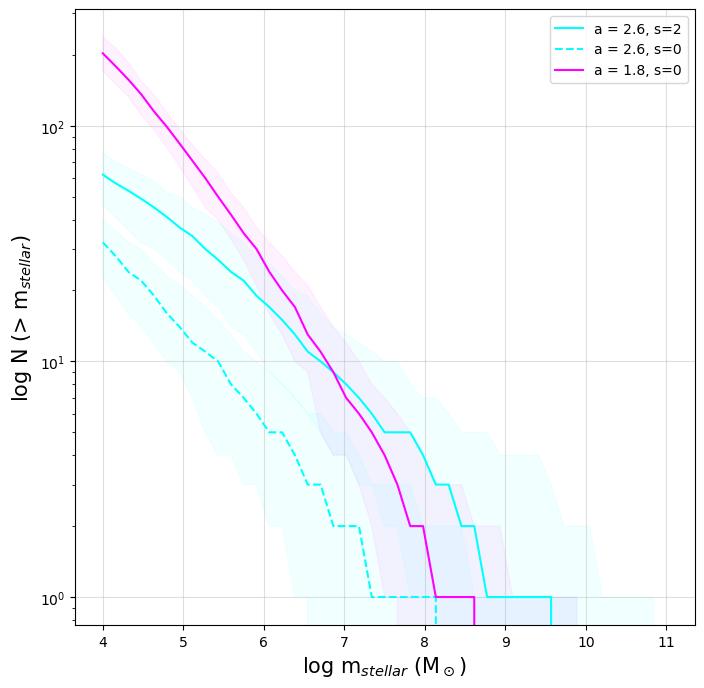

In [35]:
plt.figure(figsize=(8, 8))
plt.plot(mass_bins, quant1[1], color="cyan", label="a = 2.6, s=2")
plt.fill_between(mass_bins, y1=quant1[0], y2=quant1[2], alpha=0.05, color="cyan")

plt.plot(mass_bins, quant2[1], color="cyan", ls="--", label="a = 2.6, s=0")
plt.fill_between(mass_bins, y1=quant2[0], y2=quant2[2], alpha=0.05, color="cyan")

plt.plot(mass_bins, quant3[1], color="magenta", label="a = 1.8, s=0")
plt.fill_between(mass_bins, y1=quant3[0], y2=quant3[2], alpha=0.05, color="magenta")

plt.yscale("log")
plt.grid(alpha=0.4)
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()